In [109]:
# Abalone Dataset

# Regression Task????
# MinMax & OneHotCoder scaling gives slightly better results than Stdscaler & OrdinalEncoder
# PCA with >95% variance is still decreasing performance of models

# Kaggle is treating this as Classification task - run below
https://www.kaggle.com/sanchitvj/abalone-age-prediction

# Check below - excellent example for model compilation
https://www.kaggle.com/ragnisah/eda-abalone-age-prediction


In [1]:
# 1 Import Libs

# data structures
import pandas as pd
import numpy as np

# for graphs
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 2 Get data from file path

# lib for files access
from pathlib import Path
myfolder = Path("C:/Users/pdpc/Documents/MLfiles/Data/")


data = pd.read_excel(myfolder / "abalone.xlsx", sheet_name="abalone_unchanged") #sheet_name is not needed if only 1 tab

data.head()

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


<AxesSubplot:>

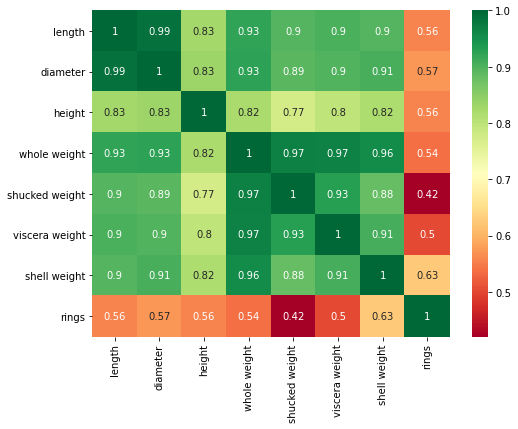

In [3]:
# 3 exlore data

# correlation matrix with formating
# control size,labels
rcParams['figure.figsize'] = 8,6
sns.heatmap(data.corr(), annot=True,cmap ='RdYlGn')

In [4]:
# 4 Prep Data

# X / y split (this will retain the data in dataframe)
target_column = ["rings"]
X  = data.drop(target_column, axis=1)
y  = data[target_column].copy()


In [5]:
# Libs for Preproc, Model

# libs Transf / Pipeline / GridSearch
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# libs for DimRed
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# libs for RegTasks
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [6]:
# Features for Transformation

num_std_features = list(X.select_dtypes(include=['int64', 'float64']).columns.values)
cat_ore_features = list(data.select_dtypes(include=['object', 'category','bool']).columns.values)

print("Features to be standardized:", num_std_features,)
print("Features to be ordinalencoded:", cat_ore_features,)

Features to be standardized: ['length', 'diameter', 'height', 'whole weight', 'shucked weight', 'viscera weight', 'shell weight']
Features to be ordinalencoded: ['sex']


In [7]:
# Preprocessor

preprocessor = ColumnTransformer(transformers=[
                    ('numTran',MinMaxScaler(),num_std_features),
                    ('catTran',OneHotEncoder(),cat_ore_features)
                    ])

In [8]:
# DimRed

pca = PCA(n_components=0.95)

# LDA not applicable to this dataset coz this is Regression Task
lda = LinearDiscriminantAnalysis()

# scale & apply PCA
dimred_pipeline = Pipeline(steps=[('preproc',preprocessor),('pca',pca)])

# PCA - fit & transform
X_reducedfeatures = dimred_pipeline.fit_transform(X)

# PCA evaluation
pca.explained_variance_ratio_
a = (np.sum(pca.explained_variance_ratio_))*100
print("Preserved variance is:", "%.2f" % a,"%","\n")
print("PCA features:",pca.explained_variance_ratio_)

Preserved variance is: 98.86 % 

PCA features: [0.47786473 0.4136805  0.09702445]


In [9]:
# Model

lin_pipeline = Pipeline(steps=[('preproc',preprocessor),('lin',LinearRegression())])
ran_pipeline = Pipeline(steps=[('preproc',preprocessor),('ran',RandomForestRegressor())])
svr_pipeline = Pipeline(steps=[('preproc',preprocessor),('svr',SVR(kernel='rbf',gamma='scale',C=100))])

In [10]:
# Splitting Train/Test for holdout/LOO
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [11]:
# Fit & Evaluate

svr_pipeline.fit(X_train,y_train)
y_pred = svr_pipeline.predict(X_test)

# Coefficients / Intercepts


# R square score actual true test value & predicted test value
from sklearn.metrics import r2_score
print("R square value for y_true & y_pred is: ", "%.4f" % r2_score(y_test,y_pred))
# MSE, RMSE, MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_test,y_pred)
print("MSE  for y_true & y_pred:              ", "%.4f" % mse)
print("RMSE for y_true & y_pred:              ", "%.4f" % np.sqrt(mse))
print("MAE  for y_true & y_pred:              ", "%.4f" % mean_absolute_error(y_test, y_pred))

C:\Users\pdpc\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R square value for y_true & y_pred is:  0.5269
MSE  for y_true & y_pred:               4.9397
RMSE for y_true & y_pred:               2.2226
MAE  for y_true & y_pred:               1.5458


In [12]:
The R square value for y_true & y_pred is:   0.5734
The MAE for for y_true & y_pred is:          1.4478

SyntaxError: invalid syntax (<ipython-input-12-fe8b5024454d>, line 1)

In [13]:
# Kfold CV

# CV/kfold libs
from sklearn.model_selection import cross_val_score, KFold
# math libs
from numpy import mean
from numpy import std
from numpy import absolute

# CV config
cv = KFold(n_splits=10, shuffle=True, random_state=1)

# evaluate the pipeline using cross validation and calculate MAE
scores = cross_val_score(svr_pipeline, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

scores = absolute(scores)
# summarize the model performance
print('MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

MAE: 1.465 (0.047)


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


ran_clf_pipeline = Pipeline(steps=[('preproc',preprocessor),('ran',RandomForestClassifier(n_estimators= 150, max_depth= 5))])
# rf = RandomForestClassifier(n_estimators= 150, max_depth= 5)
ran_clf_pipeline.fit(X_train, y_train)
y_pred = ran_clf_pipeline.predict(X_test)

print('Classification Report: \n', classification_report(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
rf_train_acc = rf.score(X_train, y_train) 
print('Training Score: ', rf_train_acc)
rf_test_acc = rf.score(X_test, y_test)
print('Testing Score: ', rf_test_acc)

C:\Users\pdpc\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\pdpc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pdpc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pdpc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: Undefine

Classification Report: 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.45      0.50      0.48        10
           5       0.35      0.27      0.31        22
           6       0.38      0.26      0.31        57
           7       0.35      0.50      0.41        78
           8       0.25      0.28      0.27       108
           9       0.19      0.45      0.27       114
          10       0.26      0.27      0.26       141
          11       0.21      0.29      0.24        91
          12       0.00      0.00      0.00        64
          13       0.00      0.00      0.00        49
          14       0.00      0.00      0.00        32
          15       0.00      0.00      0.00        15
          16       0.00      0.00      0.00        13
          17       0.00      0.00      0.00        13
          18       0.00      0.00      0.00         8
          19       0.00      0.00      0.00         8
  

NameError: name 'rf' is not defined

In [91]:
# example of using the ColumnTransformer for the Abalone dataset
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

# load dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/abalone.csv'
dataframe = read_csv(url, header=None)
# split into inputs and outputs
last_ix = len(dataframe.columns) - 1
X, y = dataframe.drop(last_ix, axis=1), dataframe[last_ix]
print(X.shape, y.shape)
# determine categorical and numerical features
numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = X.select_dtypes(include=['object', 'bool']).columns
# define the data preparation for the columns
t = [('cat', OneHotEncoder(), categorical_ix), ('num', MinMaxScaler(), numerical_ix)]
col_transform = ColumnTransformer(transformers=t)
# define the model
model = SVR(kernel='rbf',gamma='scale',C=100)
# define the data preparation and modeling pipeline
pipeline = Pipeline(steps=[('prep',col_transform), ('m', model)])
# define the model cross-validation configuration
cv = KFold(n_splits=10, shuffle=True, random_state=1)
# evaluate the pipeline using cross validation and calculate MAE
scores = cross_val_score(pipeline, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# convert MAE scores to positive values
scores = absolute(scores)
# summarize the model performance
print('MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

(4177, 8) (4177,)
MAE: 1.465 (0.047)
